In [1]:
import json
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from scipy.optimize import minimize
from matplotlib import gridspec


In [2]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [3]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [4]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [5]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [6]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [7]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [8]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = np.random.rand(2*(N+M+N*M))
    return par

In [9]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [10]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [11]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [12]:
#Gradient Descent
class GradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)

        return min, found_gs, found_gsEnergy  

In [13]:
#NelderMead
class NelderMead:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='nelder-mead', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [14]:
#BFGS
class BFGS:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='BFGS', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [15]:
#Newton-CG
class NewtonCG:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = minimize(varEnergy, par,args= (N,M,H), method='Newton-CG', options={'disp': True})
        #Ground State
        found_gs = RBM_ansatz(min.x,N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min.x, N, M,H)

        return min, found_gs, found_gsEnergy  

In [16]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


In [17]:
#Loader to test different methods with same RBM initalization
def minLoader(minimizer, par, N, M, B, A0):
    if minimizer == 'GradDescent':
        gradDescent = GradDescent(N, B, A0)
        gd = gradDescent(N, M,par)
        return gd
    if minimizer == "NelderMead":
        nelderMead = NelderMead(N,B,A0)
        nm = nelderMead(N,M,par)
        return nm
    if minimizer == "BFGS":
        bfgs = BFGS(N,B,A0)
        bf = bfgs(N,M,par)
        return bf
        
        
    

## Same Starting Paramters

In [83]:
#Parameter definition 
N= 2
M=1
B = np.pi
A0 = 1


gdResults = [] #gives ground state estimation at each iteration of gd
gdState = []
gdTime = []
gdEngErr = []
gdStateErr = []

params = []
trained_params = []

edState = []
edTime = []
ActualEng = []
hisIt = np.arange(10)

In [84]:
for i in range(10):
    par = ranRBMpar(N,M)
    params.append(par)
    #gradient descent
    gradDescent = GradDescent(N, B, A0)
    gd = gradDescent(N, M,par)
    gdResults.append(gd)
    gdState.append(gd[0])
    gdTime.append(gd[1])
    trained_params.append(gd[0][0][0])


    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    edState.append(ed[0])
    edTime.append(ed[1])

    #Error
    gdEngTemp = gd[0][2]
    edEngTemp = ed[0][0]
    ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    gdErrTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    gdEngErr.append(gdErrTemp[0])
    gdStateErr.append(gdErrTemp[1])

Optimization terminated successfully.
         Current function value: -1.898410
         Iterations: 20
         Function evaluations: 588
         Gradient evaluations: 49
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 24
         Function evaluations: 672
         Gradient evaluations: 56
Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 23
         Function evaluations: 504
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: -1.820724
         Iterations: 6
         Function evaluations: 240
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -1.820733
         Iterations: 7
         Function evaluations: 288
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: -1.898446
         Iterations: 21
         Function evaluatio

Text(0.5, 0, 'Run Number')

<Figure size 432x288 with 0 Axes>

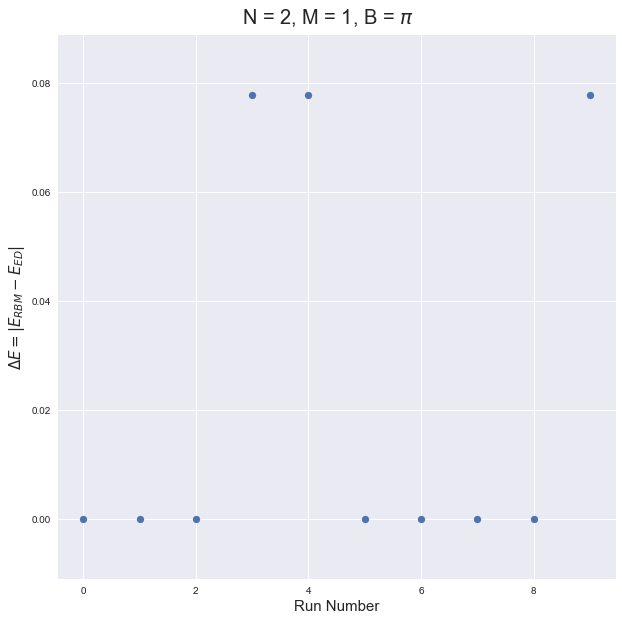

In [87]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.92])


ax4 = plt.subplot(gs[0, :])
ax4.scatter(hisIt,gdEngErr) 
ax4 .set_ylabel("$\Delta E = |E_{RBM}-E_{ED}|$", size = 15)
ax4.set_xlabel("Run Number",size = 15)


In [88]:
print(params[0])
print(trained_params[0])
print(params[3])
print(trained_params[3])



[0.99212482 0.28743273 0.85212144 0.00625628 0.30507076 0.9486696
 0.37455959 0.81331444 0.70436274 0.04721631]
[-1.60415952  0.42879771 -0.08520122 -4.42250482  4.17424146  0.94840582
  0.37480672  1.85750206  1.48796804 -0.90556927]
[0.88030007 0.02678581 0.20060769 0.6000845  0.8416192  0.40849492
 0.73339565 0.98095446 0.11248773 0.24234688]
[-3.34561756  2.61487901 -2.17305561  2.34813789 -2.12142152 -0.08905354
  1.23100161  1.08300481  1.57073146 -0.09011956]


In [89]:
x = np.arange(-4,4,0.1)

eng1 = []
for i in range(len(x)):
    param_it1 = list(trained_params[0])
    param_it1[0] = x[i]
    varEng = varEnergy(param_it1,N, M, hamiltonian(N,B,A0))
    eng1.append(varEng)
    

eng2 = []
for i in range(len(x)):
    param_it2 = list(trained_params[0])
    param_it2[1] = x[i]
    varEng = varEnergy(param_it2,N, M, hamiltonian(N,B,A0))
    eng2.append(varEng)
    

eng3 = []
for i in range(len(x)):
    param_it3 = list(trained_params[0]) 
    param_it3[2] = x[i]
    varEng = varEnergy(param_it3,N, M, hamiltonian(N,B,A0))
    eng3.append(varEng)
    

eng4 = []
for i in range(len(x)):
    param_it4 = list(trained_params[0])
    param_it4[3] = x[i]
    varEng = varEnergy(param_it4,N, M, hamiltonian(N,B,A0))
    eng4.append(varEng)

eng5 = []
for i in range(len(x)):
    param_it5 = list(trained_params[0]) 
    param_it5[4] = x[i]
    varEng = varEnergy(param_it5,N, M, hamiltonian(N,B,A0))
    eng5.append(varEng)

eng6 = []
for i in range(len(x)):
    param_it6 = list(trained_params[0]) 
    param_it6[5] = x[i]
    varEng = varEnergy(param_it6,N, M, hamiltonian(N,B,A0))
    eng6.append(varEng)


eng7 = []
for i in range(len(x)):
    param_it7 = list(trained_params[0]) 
    param_it7[6] = x[i]
    varEng = varEnergy(param_it7,N, M, hamiltonian(N,B,A0))
    eng7.append(varEng)


eng8 = []
for i in range(len(x)):
    param_it8 = list(trained_params[0]) 
    param_it8[7] = x[i]
    varEng = varEnergy(param_it8,N, M, hamiltonian(N,B,A0))
    eng8.append(varEng)

eng9 = []
for i in range(len(x)):
    param_it9 = list(trained_params[0]) 
    param_it9[8] = x[i]
    varEng = varEnergy(param_it9,N, M, hamiltonian(N,B,A0))
    eng9.append(varEng)

eng10 = []
for i in range(len(x)):
    param_it10 = list(trained_params[0]) 
    param_it10[9] = x[i]
    varEng = varEnergy(param_it10,N, M, hamiltonian(N,B,A0))
    eng10.append(varEng)

<Figure size 432x288 with 0 Axes>

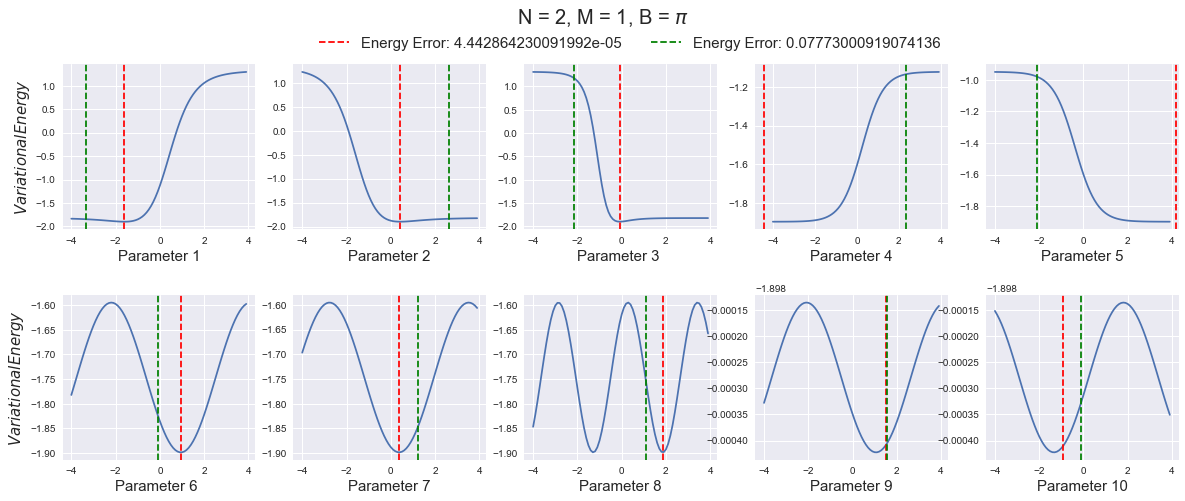

In [123]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(20,20))
ttl = plt.suptitle("N = 2, M = 1, B = $\pi$\n",size =20)
gs = gridspec.GridSpec(ncols=5, nrows=5, hspace = 0.4)
ttl.set_position([.5, 0.92])

lowErr = 'Energy Error: '+ str(gdEngErr[0])
highErr = 'Energy Error: '+ str(gdEngErr[3])
labels = [lowErr,highErr]

ax1 = plt.subplot(gs[0,0])
ax1.plot(x,eng1) 
a = ax1.axvline(trained_params[0][0],color ='r', linestyle='dashed', label=labels[0])
b = ax1.axvline(trained_params[3][0],color ='g', linestyle='dashed',label=labels[1])
ax1 .set_ylabel("$Variational Energy$", size = 15)
ax1.set_xlabel("Parameter 1",size = 15)

ax2 = plt.subplot(gs[0,1])
ax2.plot(x,eng2)  
ax2.axvline(trained_params[0][1],color ='r', linestyle='dashed')
ax2.axvline(trained_params[3][1],color ='g', linestyle='dashed')
ax2.set_xlabel("Parameter 2",size = 15)

ax3 = plt.subplot(gs[0,2])
ax3.plot(x,eng3)  
ax3.axvline(trained_params[0][2],color ='r', linestyle='dashed')
ax3.axvline(trained_params[3][2],color ='g', linestyle='dashed')
ax3.set_xlabel("Parameter 3 ",size = 15)

ax4 = plt.subplot(gs[0,3])
ax4.plot(x,eng4)  
ax4.axvline(trained_params[0][3],color ='r', linestyle='dashed')
ax4.axvline(trained_params[3][3],color ='g', linestyle='dashed')
ax4.set_xlabel("Parameter 4",size = 15)

ax5 = plt.subplot(gs[0,4])
ax5.plot(x,eng5) 
ax5.axvline(trained_params[0][4],color ='r', linestyle='dashed')
ax5.axvline(trained_params[3][4],color ='g', linestyle='dashed')
ax5.set_xlabel("Parameter 5",size = 15)

ax6 = plt.subplot(gs[1,0])
ax6 .set_ylabel("$Variational Energy$", size = 15)
ax6.plot(x,eng6)  
ax6.axvline(trained_params[0][5],color ='r', linestyle='dashed')
ax6.axvline(trained_params[3][5],color ='g', linestyle='dashed')
ax6.set_xlabel("Parameter 6 ",size = 15)

ax7 = plt.subplot(gs[1,1])
ax7.plot(x,eng7)  
ax7.axvline(trained_params[0][6],color ='r', linestyle='dashed')
ax7.axvline(trained_params[3][6],color ='g', linestyle='dashed')
ax7.set_xlabel("Parameter 7",size = 15)

ax8 = plt.subplot(gs[1,2])
ax8.plot(x,eng8)  
ax8.axvline(trained_params[0][7],color ='r', linestyle='dashed')
ax8.axvline(trained_params[3][7],color ='g', linestyle='dashed')
ax8.set_xlabel("Parameter 8",size = 15)

ax9 = plt.subplot(gs[1,3])
ax9.plot(x,eng9) 
ax9.axvline(trained_params[0][8],color ='r', linestyle='dashed')
ax9.axvline(trained_params[3][8],color ='g', linestyle='dashed')
ax9.set_xlabel("Parameter 9",size = 15)

ax10 = plt.subplot(gs[1,4])
ax10.plot(x,eng10)  
ax10.axvline(trained_params[0][9],color ='r', linestyle='dashed')
ax10.axvline(trained_params[3][9],color ='g', linestyle='dashed')
ax10.set_xlabel("Parameter 10",size = 15)

plt.legend(handles = [a, b], loc = (-3.5, 2.45),fontsize = 15,ncol=3)

In [80]:
trained_params[0][0]

-0.926702496589693

## Comparison Histograms

In [56]:
#Parameter definition 
N= 2
M=1
B = np.pi
A0 = 1

gdResults = [] #gives ground state estimation at each iteration of gd
gdState = []
gdTime = []
gdEngErr = []
gdStateErr = []

edState = []
edTime = []
ActualEng = []

nmState = []
nmTime = []
nmEngErr = []
nmStateErr = []

nwState = []
nwTime = []
nwEngErr = []
nwStateErr = []

bfState = []
bfTime = []
bfEngErr = []
bfStateErr = []

hisIt = np.arange(50)

In [57]:
for i in range(len(hisIt)):
    par = ranRBMpar(N,M)
    #gradient descent
    gd = minLoader('GradDescent',par, N, M, B, A0)
    gdResults.append(gd)
    gdState.append(gd[0])
    gdTime.append(gd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    edState.append(ed[0])
    edTime.append(ed[1])
    
    #Nelder Mead
    nm = minLoader('NelderMead',par, N, M, B, A0)
    nmState.append(nm[0])
    nmTime.append(nm[1])
    
    #BFGS
    bf = minLoader('BFGS',par, N, M, B, A0)
    bfState.append(bf[0])
    bfTime.append(bf[1])
    
    #Newton-CG
    #newtonCG = NewtonCG(N,B,A0)
    #nw = newtonCG(N,M)
    #nwState.append(nw[0])
    #nwTime.append(nw[1])
    
    
    #Error
    gdEngTemp = gd[0][2]
    nmEngTemp = nm[0][2]
    bfEngTemp = bf[0][2]
    edEngTemp = ed[0][0]
    #nwEngTemp = nw[0][2]
    
    ActualEng.append(edEngTemp)
    gdStateTemp = gd[0][1]
    edStateTemp = ed[0][1]
    nmStateTemp = nm[0][1]
    bfStateTemp = bf[0][1]
    #nwStateTemp = nw[0][1]
    
    gdErrTemp = err(gdStateTemp,edStateTemp,gdEngTemp,edEngTemp)
    nmErrTemp = err(nmStateTemp,edStateTemp,nmEngTemp,edEngTemp)
    bfErrTemp = err(bfStateTemp,edStateTemp,bfEngTemp,edEngTemp)
    #nwErrTemp = err(nwStateTemp,edStateTemp,nwEngTemp,edEngTemp)
    
    gdEngErr.append(gdErrTemp[0])
    gdStateErr.append(gdErrTemp[1])
    nmEngErr.append(nmErrTemp[0])
    nmStateErr.append(nmErrTemp[1])
    bfEngErr.append(bfErrTemp[0])
    bfStateErr.append(bfErrTemp[1])
    #nwEngErr.append(nwErrTemp[0])
    #nwStateErr.append(nwErrTemp[1])


Optimization terminated successfully.
         Current function value: -1.898454
         Iterations: 26
         Function evaluations: 636
         Gradient evaluations: 53


KeyboardInterrupt: 

In [ ]:
stateErr = [gdStateErr, nmStateErr, bfStateErr]
engErr = [gdEngErr, nmEngErr, bfEngErr]
runTime = [gdTime, nmTime, bfTime]

In [ ]:


labels = ['Gradient Descent','Nedler Mead', 'Broyden-Fletcher-Goldfarb-Shanno']
colors = ['red','blue','green']
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=3, hspace = 0.4)
ttl.set_position([.5, 0.92])



ax1 = plt.subplot(gs[0, 0])
ax1 .hist(stateErr, bins=10, label=labels, color=colors) 
ax1 .set_xlabel("$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$",size = 15)
ax1.set_ylabel("Frequency",size = 15)



ax2 = plt.subplot(gs[0, 1])
ax2.hist(engErr, bins=10, color=colors) 
ax2.set_xlabel("$\Delta E = |E_{RBM}-E_{ED}|$",size = 15)



ax3 = plt.subplot(gs[0, 2])
ax3.hist(runTime, bins=10,color=colors) 
ax3.set_xlabel("Runtime",size = 15)


ax4 = plt.subplot(gs[1, :])
ax4.set_yscale('log')
ax4.scatter(hisIt,engErr[0],color=colors[0],marker ='v') 
ax4.scatter(hisIt,engErr[1],color=colors[1],marker ='H') 
ax4.scatter(hisIt,engErr[2],color=colors[2],marker = '^') 
ax4 .set_ylabel("$\Delta E = |E_{RBM}-E_{ED}|$", size = 15)


plt.legend(labels, loc = (0, -0.3),fontsize = 12,ncol=3)

ax5 = plt.subplot(gs[2, :])
ax5.scatter(hisIt,runTime[0],color=colors[0],marker ='v') 
ax5.scatter(hisIt,runTime[1],color=colors[1],marker ='H') 
ax5.scatter(hisIt,runTime[2],color=colors[2],marker = '^') 
ax5.set_xlabel("Run Number",size = 15)
ax5 .set_ylabel("Runtime", size = 15)












<Figure size 432x288 with 0 Axes>

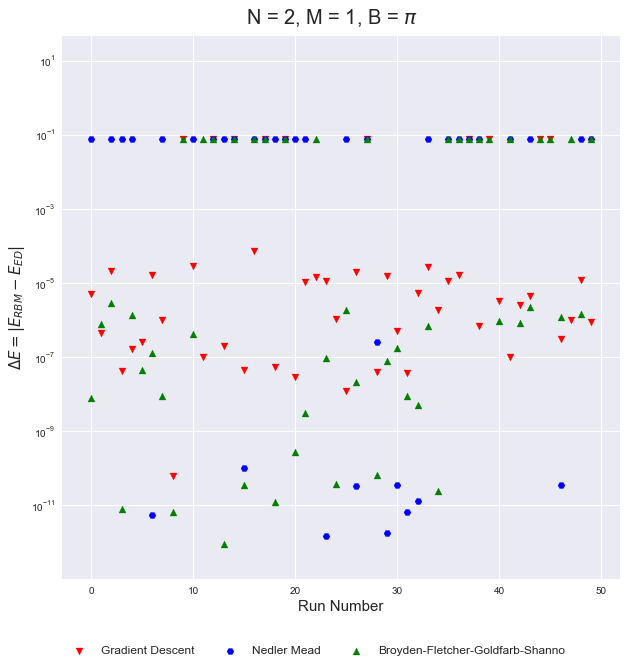

In [53]:
labels = ['Gradient Descent','Nedler Mead', 'Broyden-Fletcher-Goldfarb-Shanno']
colors = ['red','blue','green']
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 1, B = $\pi$",size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.92])


ax4 = plt.subplot(gs[0, :])
ax4.set_yscale('log')
ax4.scatter(hisIt,engErr[0],color=colors[0],marker ='v') 
ax4.scatter(hisIt,engErr[1],color=colors[1],marker ='H') 
ax4.scatter(hisIt,engErr[2],color=colors[2],marker = '^') 
ax4 .set_ylabel("$\Delta E = |E_{RBM}-E_{ED}|$", size = 15)
ax4.set_xlabel("Run Number",size = 15)
plt.legend(labels, loc = (0, -0.15),fontsize = 12,ncol=3)


